# Example comparison of damage orientation ($\alpha_c$) to the orientation of velocity ($\alpha_v$) or the principal strain angle ($\theta_p$)

Maaike Izeboud

Delft University of Technology, Department of Geoscience and Remote Sensing

#### Packages and Paths


In [1]:
import rioxarray as rioxr
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio as rio
import json

print(os.getcwd()) # path/to/git/repo/python/notebooks
os.chdir('../../') # go to parent, path/to/git/repo/

this_dir = os.getcwd() # path/to/git/repo/
data_path = os.path.join(this_dir,'data/')


/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/CrevasseDetection/NormalisedRadonTransform/python/notebooks


## Load damage and orientation

#### Calculate alpha_c from theta_c
$\alpha_c = \theta_{crev} - 90$, such that $\alpha_c$ is [-90 to 90] wrt image horizontal

#### Calculate $\hat{D}$ from $\sigma_{crev}$
$\hat{D} = \sigma_{crev} - \tau_{crev}$ 
With $\tau_{crev}$ a function of the source (Sentinel 2), image pixel resolution (30m) and processed window size (10 pixels)


In [2]:

nc_file = 'example_S2_median_2020-12-1_2021-3-1_output_10px.nc'
threshold_file = os.path.join(this_dir,'files/dmg_threshold_dictionary.json')
da_result = xr.open_dataarray(os.path.join(data_path, 'damage_detection/', nc_file))
da_result = da_result.rio.write_crs(3031, inplace=True)


with open(threshold_file, 'r') as fp:
    threshold_dict = json.load(fp) 

# select threshold value
wsize = da_result.attrs['window_size(px)'] # e.g. 10px 
img_res=da_result.attrs['img_res'] # original image resolution (m) 
threshold = threshold_dict['S2']['img_res'][str(img_res)][str(wsize)+'px'] 

# calculate alpha_c and dmg
alpha_c = da_result.isel(out=0) - 90
crevSig = da_result.isel(out=1)
dmg = crevSig - threshold
dmg = dmg.where(dmg>0)




### Load velocity data and calculate angle

In [3]:

file_vy = 'example_G0240_vx.tif'
file_vx = 'example_G0240_vy.tif'
vx = rioxr.open_rasterio(os.path.join(data_path,file_vx))
vy = rioxr.open_rasterio(os.path.join(data_path,file_vy))
# fig,axs = plt.subplots(1,2)
# vx.plot(ax=axs[0])
# vy.plot(ax=axs[1])

# Velocity angle
alpha_v = np.arctan(vy/vx)/(2*np.pi) * 360


### Calculate principal strain and its orientation

#### Principal Strain:
$ \dot\epsilon_{ij}= \begin{bmatrix} \epsilon_{xx} & \epsilon_{xy} \\ \epsilon_{yx} & \epsilon_{yy} \end{bmatrix} $

and

$ \dot\epsilon_{ij} = \frac{1}{2}\left( \frac{\delta u_i}{\delta x_j} + \frac{\delta u_j}{\delta x_i} \right)$


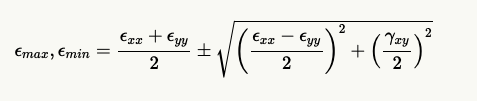



#### Orientation of Principal Strain

$\tan(2\cdot\theta_{princip}) = \frac{2\cdot\epsilon_{xy}}{\epsilon_{xx} - \epsilon_{yy}}$

$ \textbf{Q}= \begin{bmatrix} cos(\theta_p)  & sin(\theta_p) \\ -sin(\theta_p) & cos(\theta_p) \end{bmatrix} $

and $ \textbf{E'}= \textbf{Q} \cdot \textbf{E} \cdot \textbf{Q}^T $

#### 
See: https://www.continuummechanics.org/principalstressesandstrains.html and https://www.continuummechanics.org/strain.html



In [4]:
# spatial resolution
dx = np.unique(np.diff(vx['x'].values))[0]
dy = np.unique(np.diff(vx['y'].values))[0]
print(dx,dy)

240.0 -240.0


In [5]:
# Check if theta_p aligns with e_max or e_min
def check_theta_p_e11_e22(exx,eyy,exy,theta_p):
        
    E = np.array([ [exx.squeeze(), exy.squeeze() ], 
                [exy.squeeze(), eyy.squeeze() ] ]) # shape (2, 2, 494, 401) 

    Q = np.array([ [ np.cos(theta_p.squeeze()), np.sin(theta_p.squeeze())], 
                [-np.sin(theta_p.squeeze()), np.cos(theta_p.squeeze())] ])  # shape  (2, 2, 494, 401)  

    Qt = np.transpose(Q, (1, 0, 2, 3)) # (2, 2, 494, 401); transposed the (2,2) axes

    # move axes for np.matmul (from (2,2,x,y) to (x,y, 2, 2 ))
    E = np.moveaxis(E, [0, 1], [-2, -1]) 
    Q = np.moveaxis(Q, [0, 1], [-2, -1]) 
    Qt = np.moveaxis(Qt, [0, 1], [-2, -1]) 

    Edot = np.matmul(np.matmul(Q,E),Qt)

    # Update_theta_p to match e11
    e11 = Edot[:,:,0,0]
    e22 = Edot[:,:,1,1] 
    ndec = 6

    # idx where emax=e11, theta_p is correct 
    idx_e11_eq_emax = e11.round(ndec) == emax.values.round(ndec) 

    # idx where emax=e22, theta_p should be + 90 degree
    idx_e22_eq_emax = e22.round(ndec) == emax.values.round(ndec) 

    # if emax is not e11, it should be e22 -- fix rounding errors
    idx_correct = ~idx_e11_eq_emax == idx_e22_eq_emax 
    idx_correct[np.isnan(e11)] = True # remove nan values
    if not idx_correct.all():
        diff_e11 = np.nan_to_num(np.abs(emax-e11))
        diff_e22 = np.nan_to_num(np.abs(emax-e22)) 
        min_diff =  np.array((diff_e11,diff_e22)).min(axis=0)
        mindiff_e11_or_e22 = np.array((diff_e11,diff_e22)).argmin(axis=0) # 0 of minimum is found in e11; 1 if minimum diff is found in e22
        mindiff_e11_or_e22[idx_correct] = -999                # skip pixels that were already correct
        idx_e11_eq_emax[np.where(mindiff_e11_or_e22 == 0)] = True
        idx_e22_eq_emax[np.where(mindiff_e11_or_e22 == 1)] = True
        idx_correct = ~idx_e11_eq_emax == idx_e22_eq_emax 
        idx_correct[np.isnan(e11)] = True

    return idx_e22_eq_emax



In [6]:
# Prinicipal strain values 

pix = 1  # number of pixels to shift
res = dx # spatial resolution of grid

dudx = (vx-vx.roll(x=pix) )/res
dvdy = (vy-vy.roll(y=pix) )/res
dudy = (vx-vx.roll(y=pix) )/res
dvdx = (vy-vy.roll(x=pix) )/res
exx = 0.5*(dudx+dudx)
eyy = 0.5*(dvdy+dvdy)
exy = 0.5*(dudy+dvdx)
emax_xr = (exx+eyy)*0.5 + np.sqrt(np.power(exx-eyy,2)*0.25+np.power(exy,2))
emax = emax_xr.squeeze()

emin_xr = (exx+eyy)*0.5 - np.sqrt(np.power(exx-eyy,2)*0.25+np.power(exy,2))
emin = emin_xr.squeeze()


# Orientation of principal strain

theta_p = (np.arctan(2*exy/(exx-eyy))/2) # in radians

#  Check if theta_p aligns with e_min or e_max, and update theta_p value + 0.25 pi

idx_e22_eq_emax = check_theta_p_e11_e22(exx,eyy,exy,theta_p)
theta_p = theta_p.squeeze().values
theta_p[idx_e22_eq_emax] +=  np.pi/4 # 90 degrees is 1/4 pi 

theta_p_degr = theta_p*360/(2*np.pi)
# convert back to xarray dataArray
theta_p_degr = emax_xr.copy(data=np.expand_dims(theta_p_degr,axis=0))


## Match matrix grids

In [7]:
# reproject_match from rasterio

# -- match grid (extent, resolution and projection)
theta_p_match = theta_p_degr.rio.reproject_match(alpha_c,resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308
alpha_v_match = alpha_v.rio.reproject_match(alpha_c,resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308




# Calculate relative orientation


$\theta_p$, $\alpha_v$ and $\alpha_c$ are $[-90, 90]$

$\Delta\alpha$ is therefore $[-180, 180]$


In [8]:

# with theta_p and alpha_c in [-90 to 90], Dalpha=[-180 to 180]
delta_theta = theta_p_match - alpha_c 
delta_alpha = alpha_v_match - alpha_c


print(delta_alpha.min().values,delta_alpha.max().values) # [-180 180]
print(delta_theta.min().values,delta_theta.max().values) # [-135 180]


-174.47081756591797 176.61418914794922
-129.78188705444336 176.81227111816406


# Plot dmg angle ($\alpha_c$)

In [9]:

def plot_angle_and_quiver2(img,alpha,dmg,ftitle='angle',clipBounds=None,scale=0.4,width=100,headwidth=4,figsize=(8,8)):
  
    # angle = alpha.where(dmg.values!=0)# degreess
    angle=alpha
     
    if clipBounds is not None:
        min_lon, min_lat, max_lon, max_lat = clipBounds
        angle = angle.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
        dmg = dmg.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
        img = img.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
        # img = img.rio.clip_box(minx=min_lon-1000, miny=min_lat-1000, maxx=max_lon+1000, maxy=max_lat+1000) # buffer img
        
    
    x = angle['x']
    y = angle['y']   
    
    # arrow_length = 150
    # # arrow_length = dmg*8000 # scale lenngth with dmg
    # arrow_length = 250 + dmg*3000
    arrow_length = 300+dmg*3000
    
    u = arrow_length * np.cos(np.deg2rad(angle.values) )
    v = arrow_length * np.sin(np.deg2rad(angle.values) )
    
    fig,axs=plt.subplots(1,1,figsize=figsize)
    h1 = img.plot.imshow(ax=axs,cmap='gray',cbar_kwargs={"fraction": 0.046})
    # h1 = axs.imshow(img.data)
    axs.quiver(x,y, u,v,
                angles='uv',
                units='x',
                scale=scale, #1.1,#0.8,#0.4,
                scale_units='x', # sclae_unit 'x': unit will be 0.5 xax units -- setting scale=1 means 0.5xaxunit, scale > 1:  means <0.5xaxunit (smaller), scale=0-1: bigger
                width=width, #120,#100, # 0.005 typical starting value
                headwidth=headwidth,#4, # default 3
                pivot='mid',
                # color='hotpink',
               color='orangered',
                # color=cm_data[int(len(cm_data)/2),:] # ROMA green
                # color='#faccfa', # ROMA pink
                # color= '#d29343', # ROMA orange
                # color='#011959', #ROMA BLUE
                 )
    axs.set_aspect('equal')
    axs.set_title(ftitle)
    fig.tight_layout()
    # fig.colorbar(h1).remove()
    # plt.draw()

    return fig, axs

def aggregate_values(alpha,dmg,ksize=3):
    
    alpha_mask = alpha.where(dmg!=0)

    ## COARSEN alpha_c

    dx=3

    # MEDIAAN OF FILTERED MEDIAN
    alpha_coarsen  = alpha_mask.coarsen(x=ksize,y=ksize,boundary='trim').median() # median for angle
    dmg_coarsen    = dmg.coarsen(x=ksize,y=ksize,boundary='trim').max() # max for dmg
    
    return alpha_coarsen, dmg_coarsen


def quiver_analysis(tileNum,clipBounds=None,quiver_kwargs=(0.4,150,3),figsize=(8,8)):

    img, alpha_mask, dmg = get_tiffs_tile(tileNum)

    
    ## AGGREGATE ANGLE VALUES
    
    alpha_coarsen, dmg_coarsen = aggregate_values(alpha_mask,dmg,ksize=3)

    scale, width, headwidth= quiver_kwargs #(0.4,150,3) # 


    fig,ax = plot_angle_and_quiver(img, alpha_coarsen, dmg_coarsen,
                          ftitle='angle coarsened (median)',clipBounds=clipBounds,
                          scale=scale,width=width,headwidth=headwidth,figsize=figsize )
    
    return fig,ax




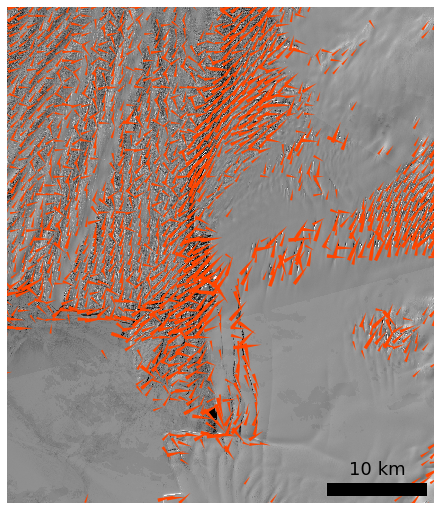

In [12]:

## PINE ISLAND ZOOMBOX 
min_lon = -1.605e6 
min_lat = -330e3
max_lon = -1.562e6 
max_lat = -280e3 
clip_bounds = (min_lon, min_lat,max_lon,max_lat)

img_file = 'example_S2_median_2020-12-1_2021-3-1.tif'
img = xr.open_dataarray(os.path.join(data_path, img_file)).isel(band=0); img.attrs['long_name']='B4'
img.rio.write_crs(3031, inplace=True)
    
# clip_bounds
min_lon, min_lat, max_lon, max_lat = clip_bounds


## AGGREGATE ANGLE VALUES (plot fewer quivers than values)

alpha_coarsen, dmg_coarsen = aggregate_values(alpha_c.where(dmg>=0),dmg,ksize=3)

## PLOT QUIVER

scale, width, headwidth= (0.3,350,1) # quiver params 

fig,ax = plot_angle_and_quiver2(img, alpha_coarsen, dmg_coarsen,
                        ftitle='angle coarsened (median)',clipBounds=clip_bounds,
                        scale=scale,width=width,headwidth=headwidth,figsize=(8,8) )
ax.set_title('')
ax.set_xlim([min_lon,max_lon])
ax.set_ylim([min_lat,max_lat])
ax.set_xlabel('x (m)'); ax.set_ylabel('y (m)')
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0))
ax.locator_params(axis='y', nbins=3)
ax.locator_params(axis='x', nbins=3)

a = ax.images[-1]
cb = a.colorbar  
cb.remove()
ax.set_aspect('equal')
ax.set_axis_off()

scalebar = ScaleBar(1,
            location='lower right',
            pad=None,
            border_pad=0.5,
            box_alpha=0,
            scale_loc='top',
            width_fraction=0.025,
            length_fraction=0.3,
            font_properties={'size':18},
            )

ax.add_artist(scalebar);

    


# Plot relative orientations ($\Delta\alpha_p$ and $\Delta\alpha_v$)

In [13]:
# make colormap
# load roma
from matplotlib.colors import LinearSegmentedColormap      
os.chdir(os.path.join(this_dir,'files'))
import romaO
os.chdir(this_dir)

cm_data = romaO.cm_data # np.loadtxt(path2roma + 'roma.txt')

roma_2x= np.concatenate((cm_data,np.flip(cm_data,axis=0)))
roma_4x= np.concatenate((roma_2x, np.flip(roma_2x,axis=0)))
cm_data=roma_4x

roma_map = LinearSegmentedColormap.from_list('roma', cm_data)      
 

Text(0.5, 1.0, 'delta_alpha masked')

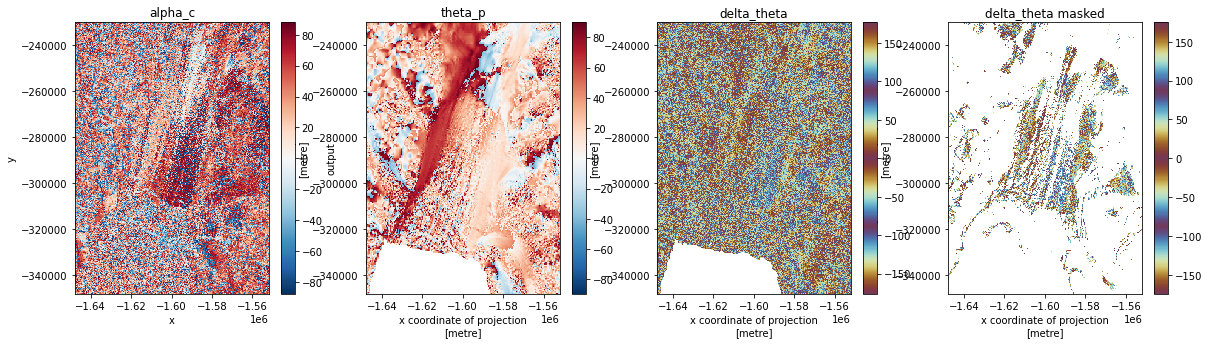

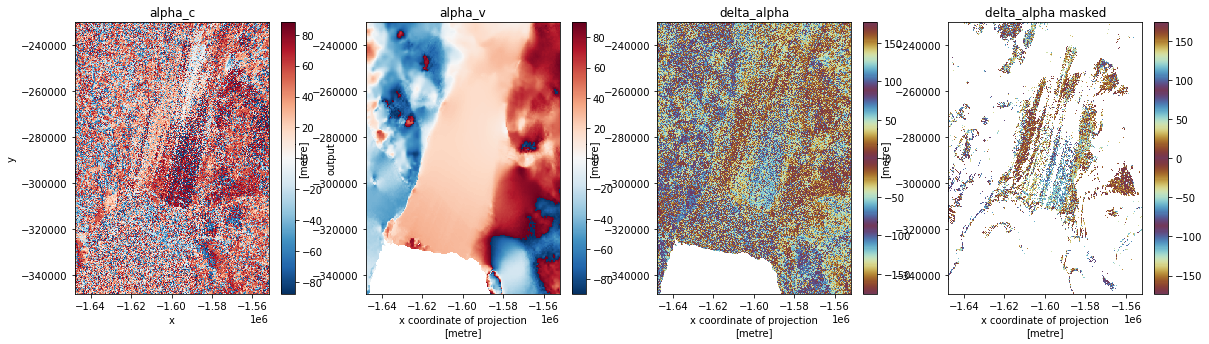

In [14]:
fig,axs=plt.subplots(1,4,figsize=(20,5))
alpha_c.plot(ax=axs[0])
axs[0].set_title('alpha_c')
theta_p_match.plot(ax=axs[1])
axs[1].set_title('theta_p')
delta_theta.plot(ax=axs[2],cmap=roma_map)
axs[2].set_title('delta_theta')
delta_theta.where(dmg>0).plot(ax=axs[3],cmap=roma_map)
axs[3].set_title('delta_theta masked')

fig,axs=plt.subplots(1,4,figsize=(20,5))
alpha_c.plot(ax=axs[0])
axs[0].set_title('alpha_c')
alpha_v_match.plot(ax=axs[1])
axs[1].set_title('alpha_v')
delta_alpha.plot(ax=axs[2],cmap=roma_map)
axs[2].set_title('delta_alpha')
delta_alpha.where(dmg>0).plot(ax=axs[3],cmap=roma_map)
axs[3].set_title('delta_alpha masked')


Text(0.5, 1.0, 'delta_alpha velo ')

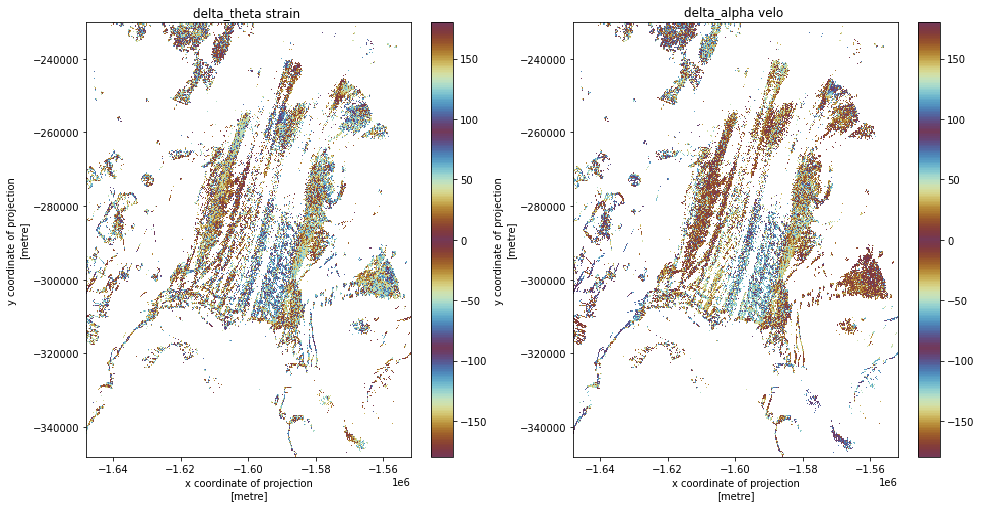

In [15]:
fig,axs=plt.subplots(1,2,figsize=(16,8))

delta_theta.where(dmg>0).plot(ax=axs[0],cmap=roma_map,vmin=-180,vmax=180)
axs[0].set_title('delta_theta strain ')

delta_alpha.where(dmg>0).plot(ax=axs[1],cmap=roma_map,vmin=-180,vmax=180)
axs[1].set_title('delta_alpha velo ')